In [ ]:
### Assignment 2

# Q1

In [ ]:
# Question 1

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [ ]:
data = pd.read_csv('https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv?sc_lang=en&hash=80445D12401C59CF716410F3F7863B64')

In [ ]:
# Clean the data to get the log difference of INDPRO

data['INDPRO'] = pd.to_numeric(data['INDPRO'], errors='coerce')
data = data.dropna(subset=['INDPRO'])
data['log_diff_INDPRO'] = np.log(data['INDPRO']).diff().dropna()

y = data['log_diff_INDPRO'].dropna().values

In [ ]:
# Define the conditional Log Likelihood Function
def conditional_log_likelihood(params, y):
    c, phi1, phi2, sigma = params
    residuals = y[2:] - c - phi1 * y[1:-1] - phi2 * y[:-2]
    ll = -0.5 * np.sum(np.log(2 * np.pi * sigma**2) + (residuals**2) / sigma**2)
    return -ll

In [ ]:
# Define the unconditional Log Likelihood Funtion
def unconditional_log_likelihood(params, y):
    c, phi1, phi2, sigma = params
    var = sigma**2 / (1 - phi1**2 - phi2**2)
    ll_init = -0.5 * np.sum(np.log(2 * np.pi * var) + (y[:2]**2) / var)
    residuals = y[2:] - c - phi1 * y[1:-1] - phi2 * y[:-2]
    ll = -0.5 * np.sum(np.log(2 * np.pi * sigma**2) + (residuals**2) / sigma**2)
    return -(ll + ll_init)

In [ ]:
# Create initial parameters and bounds
initial_params = [0, 0.5, 0.5, 1]
bounds = [(None, None), (None, None), (None, None), (1e-6, None)]

In [ ]:
# Get Conditional Likelihood parameters by minimizing the negatice -log-likelihood, therefore maximizing Log-likelihood
result_cond = minimize(conditional_log_likelihood, initial_params, args=(data[2:],),
                       method='L-BFGS-B', bounds=bounds)
print("Conditional Likelihood:")
print(f"c: {result_cond.x[0]:.6f}, phi1: {result_cond.x[1]:.6f}, phi2: {result_cond.x[2]:.6f}, sigma: {result_cond.x[3]:.6f}")

In [ ]:
result_cond = minimize(conditional_log_likelihood, initial_params, args=(y[2:],),
                       method='L-BFGS-B', bounds=bounds)
print("Conditional Likelihood:")
print(f"c: {result_cond.x[0]:.6f}, phi1: {result_cond.x[1]:.6f}, phi2: {result_cond.x[2]:.6f}, sigma: {result_cond.x[3]:.6f}")

Conditional Likelihood:
c: 0.001440, phi1: 0.307036, phi2: -0.069284, sigma: 0.009467


In [ ]:
# Get Unconditional Likelihood parameters by minimizing the negatice -log-likelihood, therefore maximizing Log-likelihood
result_uncond = minimize(unconditional_log_likelihood, initial_params, args=(data,),
                         method='L-BFGS-B', bounds=bounds)
print("Unconditional Likelihood:")
print(f"c: {result_uncond.x[0]:.6f}, phi1: {result_uncond.x[1]:.6f}, phi2: {result_uncond.x[2]:.6f}, sigma: {result_uncond.x[3]:.6f}")

Unconditional Likelihood:
c: 0.050755, phi1: 0.125192, phi2: -0.217543, sigma: 0.977582


In [ ]:
result_uncond = minimize(unconditional_log_likelihood, initial_params, args=(y,),
                         method='L-BFGS-B', bounds=bounds)
print("Unconditional Likelihood:")
print(f"c: {result_uncond.x[0]:.6f}, phi1: {result_uncond.x[1]:.6f}, phi2: {result_uncond.x[2]:.6f}, sigma: {result_uncond.x[3]:.6f}")

Unconditional Likelihood:
c: -0.291080, phi1: 0.132150, phi2: -0.293127, sigma: 0.611530


/var/folders/2l/0ynsc5t90bj6_gtg0m_qfvy80000gn/T/ipykernel_76436/1881661215.py:4: RuntimeWarning: invalid value encountered in log
  ll_init = -0.5 * np.sum(np.log(2 * np.pi * var) + (y[:2]**2) / var)


In [ ]:
# Define the OLS estimation for generalized AR(p) model
def fit_ar_ols(data, p):
    """
    OLS estimation for AR(p) model with a constant term.

    data: observed data.
    p: order of the AR model.
    """
    T = len(data)
    Y = data[p:]  # from p
    X = np.column_stack([data[p - i - 1:T - i - 1] for i in range(p)])
    X = np.column_stack((np.ones(X.shape[0]), X))  # c

    # OLS beta = (X'X)^-1 X'Y
    XTX = np.dot(X.T, X)
    XTY = np.dot(X.T, Y)
    beta_hat = np.linalg.solve(XTX, XTY)

    return beta_hat

In [ ]:
# Extract AR(2) coefficients
p = 2
beta_hat = fit_ar_ols(data, p)
print("Estimated AR coefficients:", beta_hat)

Estimated AR coefficients: [ 0.05077606  0.12709428 -0.22057533]


In [ ]:
p = 2
beta_hat = fit_ar_ols(y, p)
print("Estimated AR coefficients:", beta_hat)

Estimated AR coefficients: [0.00135987 0.28940705 0.00269299]


# Q2-3

In [ ]:
# Question 2 & 3

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

In [ ]:
# Clean dataset to get log diff

data = pd.read_csv('https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv?sc_lang=en&hash=80445D12401C59CF716410F3F7863B64')
data = data.iloc[1:].copy()
data['INDPRO'] = pd.to_numeric(data['INDPRO'], errors='coerce')
data.dropna(subset=['INDPRO'], inplace=True)

log_diff = np.log(data['INDPRO']).diff().dropna()

In [ ]:
# Define the AR likelihood funtion
def ar_likelihood(params, y, p):
    c = params[0]
    phi = params[1:p+1]  # AR
    sigma2 = params[-1]

    T = len(y)
    residuals = y[p:] - c - np.dot(np.column_stack([y[p-j-1:T-j-1] for j in range(p)]), phi)
    log_likelihood = (-T/2 * np.log(2 * np.pi * sigma2) - np.sum(residuals**2) / (2 * sigma2))

    return -log_likelihood

In [ ]:
# AR estimate
def estimate_ar_parameters(y, p):
    params_initial = np.zeros(p+2)
    params_initial[-1] = 1.0  # initial variance = 1

    bounds = [(None, None)] + [(-1, 1) for _ in range(p)] + [(1e-6, None)]
    result = minimize(ar_likelihood, params_initial, args=(y, p), bounds=bounds)

    if result.success:
        return result.x
    else:
        raise Exception("fault:", result.message)

In [ ]:
# Plugging data of INDPRO into defined function to get Unconditional Log-likelihood and Estimated parameters
p = 2
params = estimate_ar_parameters(log_diff, p)
print("Estimated parameters:", params)
data = log_diff

#Finding Unconditional Log-likelihood
unconditional_log_likelihood = ar_likelihood(params, data, p)
print("Unconditional Log-Likelihood:", unconditional_log_likelihood)

Estimated parameters: [1.34853758e-03 2.82715249e-01 1.29836896e-02 9.01881518e-05]
Unconditional Log-Likelihood: -2564.369111208988


In [ ]:
# OLS to AR paras
def fit_ar_ols(y, p):
    T = len(y)
    Y = y[p:]
    X = np.column_stack([y[p-i-1:T-i-1] for i in range(p)])
    X = np.column_stack((np.ones(X.shape[0]), X))

    beta_hat = np.linalg.solve(X.T @ X, X.T @ Y)
    return beta_hat

In [ ]:
# Create the MLE and OLS Estimation parameters
p = 2
params_mle = estimate_ar_parameters(log_diff, p)
params_ols = fit_ar_ols(log_diff, p)

print("MLE Estimation Not Restore Originals:", params_mle)
print("OLS Estimation:", params_ols)


MLE Estimation Not Restore Originals: [1.34853758e-03 2.82715249e-01 1.29836896e-02 9.01881518e-05]
OLS Estimation: [ 0.00145197  0.30873154 -0.06607547]


In [ ]:
# prediction for future 8 months
future_steps = 8
predictions_mle, predictions_ols = [], []
past_values = list(log_diff[-p:])

for _ in range(future_steps):
    next_pred_mle = params_mle[0] + sum(params_mle[i+1] * past_values[-(i + 1)] for i in range(p))
    next_pred_ols = params_ols[0] + sum(params_ols[i+1] * past_values[-(i + 1)] for i in range(p))

    predictions_mle.append(next_pred_mle)
    predictions_ols.append(next_pred_ols)
    past_values.append(next_pred_mle)


In [ ]:
# reduction to the original scale
data['INDPRO_forecast_mle'] = np.nan
data['INDPRO_forecast_ols'] = np.nan
last_value = data['INDPRO'].iloc[-1]

forecast_values_mle = [last_value * np.exp(sum(predictions_mle[:i+1])) for i in range(future_steps)]
forecast_values_ols = [last_value * np.exp(sum(predictions_ols[:i+1])) for i in range(future_steps)]
actual_values = data['INDPRO'].iloc[-future_steps:].values


print("Prediction for Future 8 Months (MLE):", forecast_values_mle)
print("Prediction for Future 8 Months (OLS):", forecast_values_ols)
print("Actual value for 8 months:", actual_values)



Prediction for Future 8 Months (MLE): [np.float64(103.81384287204067), np.float64(104.04673311426546), np.float64(104.25711847891566), np.float64(104.46048373671142), np.float64(104.66183660444264), np.float64(104.86279816537261), np.float64(105.06389341751212), np.float64(105.26529272059089)]
Prediction for Future 8 Months (OLS): [np.float64(103.75753296814125), np.float64(103.96693917466347), np.float64(104.16995048331617), np.float64(104.37093562039138), np.float64(104.57153347032202), np.float64(104.7722657453328), np.float64(104.97330210686727), np.float64(105.17469793290022)]
Actual value for 8 months: [103.2534 102.5192 103.0196 102.5873 102.1219 101.9736 102.9833 103.511 ]


In [ ]:
# calculation of forecast error
actual_values = data['INDPRO'].iloc[-future_steps:].values
mse_mle = np.mean((forecast_values_mle - actual_values) ** 2)
mse_ols = np.mean((forecast_values_ols - actual_values) ** 2)

forecast = {
    "Month": range(1, 9),  # Months 1 to 8
    "MLE Prediction": forecast_values_mle,
    "OLS Prediction": forecast_values_ols,
    "Actual Value": actual_values
}

forecast_table = pd.DataFrame(forecast)
forecast_table.loc[len(forecast_table)] = ["MSE", mse_mle, mse_ols, np.nan]

print(forecast_table)

  Month  MLE Prediction  OLS Prediction  Actual Value
0     1      103.813843      103.757533      103.2534
1     2      104.046733      103.966939      102.5192
2     3      104.257118      104.169950      103.0196
3     4      104.460484      104.370936      102.5873
4     5      104.661837      104.571533      102.1219
5     6      104.862798      104.772266      101.9736
6     7      105.063893      104.973302      102.9833
7     8      105.265293      105.174698      103.5110
8   MSE        3.736610        3.426999           NaN


In [ ]:
if mse_mle < mse_ols:
    print("The smaller prediction error of the MLE method indicates that its prediction performance on this dataset is better than that of OLS.")
else:
    print("The smaller prediction error of the OLS method indicates that its prediction performance on this dataset is better than that of MLE.")

print("Possible reasons include:\n1. The OLS method is more robust to larger samples and may be less affected by outliers.\n2. The MLE method relies on assumptions about the error distribution, which may affect its predictive effectiveness if the data do not satisfy the normality assumption.")

The smaller prediction error of the OLS method indicates that its prediction performance on this dataset is better than that of MLE.
Possible reasons include:
1. The OLS method is more robust to larger samples and may be less affected by outliers.
2. The MLE method relies on assumptions about the error distribution, which may affect its predictive effectiveness if the data do not satisfy the normality assumption.


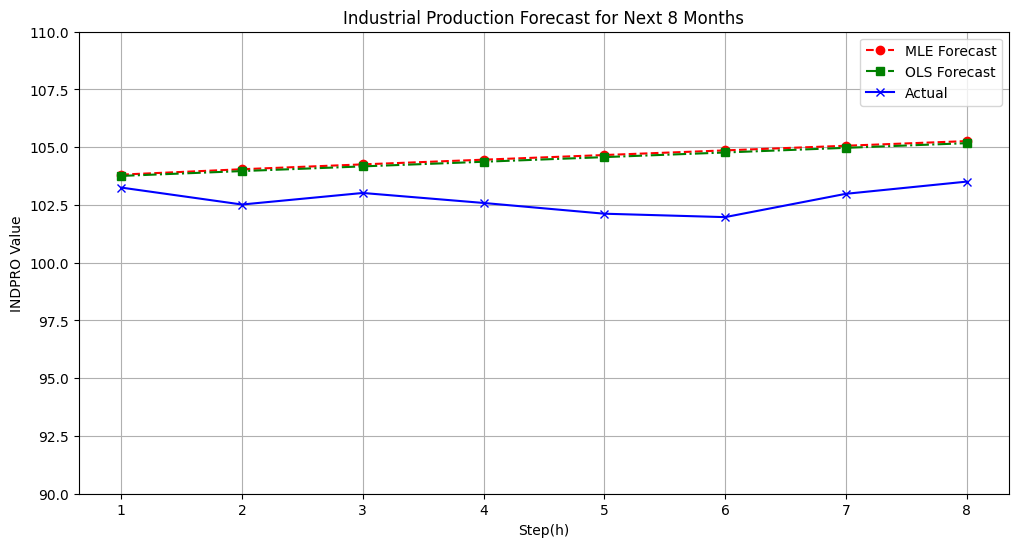

In [ ]:
# Plotting forecast and actual value to compare
import matplotlib.pyplot as plt
steps = range(1, future_steps + 1)

# Plot the forecasted values vs actual value
plt.figure(figsize=(12, 6))
plt.plot(steps, forecast_values_mle, label='MLE Forecast', color='red', linestyle='--', marker='o')
plt.plot(steps, forecast_values_ols, label='OLS Forecast', color='green', linestyle='-.', marker='s')
plt.plot(steps, actual_values, label='Actual', color='blue', linestyle='-', marker='x')

plt.title('Industrial Production Forecast for Next 8 Months')
plt.xlabel('Step(h)')
plt.ylabel('INDPRO Value')
plt.xticks(steps)
plt.legend()
plt.grid(True)
plt.ylim(90, 110)

plt.show()

Graphically, the forecast is quite close to real data